<a href="https://colab.research.google.com/github/darkzard05/kaggle/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [578]:
# Kaggle 타이타닉 문제는 타이타닉의 승객 중에 생존 유무를 예측하는 것이다.
# 아래의 코드는 https://www.kaggle.com/startupsci/titanic-data-science-solutions 를 참고해서 작성하였다.

In [579]:
# Numpy, Pandas 불러오기
import numpy as np
import pandas as pd

# 시각화 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 머신러닝 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# 특성 중요도 라이브러리 불러오기
!pip install eli5
import eli5 
from eli5.sklearn import PermutationImportance

In [580]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [581]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/test.csv')

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [582]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [583]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [584]:
train_label = train['Survived']
test_id = test['PassengerId']
train.drop(['Survived'], axis=1, inplace=True)
total = pd.concat([train, test], axis=0).iloc[:,1:]
total.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean    446.000000    2.308642   29.699118    0.523008    0.381594   32.204208
std     257.353842    0.836071   14.526497    1.102743    0.806057   49.693429
min       1.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    2.000000   20.125000    0.000000    0.000000    7.910400
50%     446.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    3.000000   38.000000    1.000000    0.000000   31.000000
max     891.000000    3.000000   80.000000    8.000000    6.000000  512.329200
--------------------
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cbb63b190>,
      dtype=object)

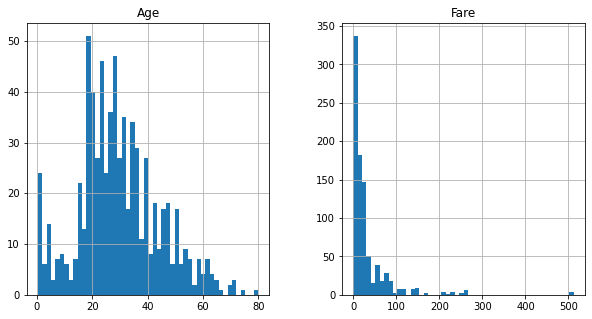

In [585]:
# 데이터 요약
print(train.describe())
print('-'*20)
print(test.describe())

# Fare에 이상치가 존재한다.
train.loc[:,['Age', 'Fare']].hist(bins=50, figsize=(10, 5))

In [586]:
# Training, Test 세트의 결측치 확인하기
# Age, Cabin, Fare, Embarked에서 결측치가 있다.
print(train.isnull().sum())
print('-'*20)
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


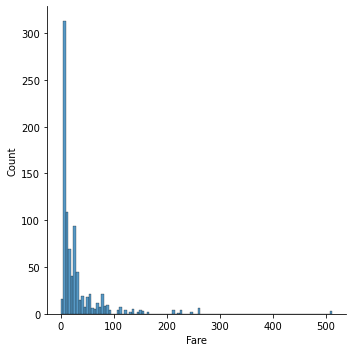

In [587]:
sns.displot(train['Fare'])
train['Fare'] = np.log1p(train['Fare'])

In [588]:
total['Has_Same_Ticket'] = total.groupby('Ticket')['Ticket'].transform('count')
total.drop(['Ticket'], axis=1, inplace=True)
total.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Has_Same_Ticket
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,2
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,2
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1


In [589]:
print(total['Cabin'].apply(lambda x:x[:1] if type(x) == str else x).value_counts())
print('-'*20)

total['Cabin'] = total['Cabin'].apply(lambda x:x[:1] if type(x) == str else 'M')
total['Cabin'] = total['Cabin'].replace(['A', 'B', 'C', 'T'], 'ABC')
total['Cabin'] = total['Cabin'].replace(['D', 'E'], 'DE')
total['Cabin'] = total['Cabin'].replace(['F', 'G'], 'FG')
print(total['Cabin'].value_counts())

total = pd.get_dummies(data=total, columns=['Cabin'], prefix='Cabin')
total.head()

# # Has_Cabin은 생존율에 연관이 있는 것으로 보인다.
# print(train[['Has_Cabin', 'Survived']].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False))

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Cabin, dtype: int64
--------------------
M      1014
ABC     182
DE       87
FG       26
Name: Cabin, dtype: int64


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Same_Ticket,Cabin_ABC,Cabin_DE,Cabin_FG,Cabin_M
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1,0,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,1,0,0,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,0,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,1,0,0,0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,0,0,0,1


In [590]:
# Name에서 Title으로 추출해서 구분한다.
total['Title'] = total['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

total['Married'] = 0
total.loc[total['Title'] == 'Mrs', 'Married'] = 1

# 희귀한 Title은 Others로 변환한다.
total['Title'] = total['Title'].replace(['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme',
                                         'Countess', 'Dona'], 'MissMrs')
total['Title'] = total['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt',
                                         'Sir', 'Don', 'Rev'], 'Others')
total = pd.get_dummies(data=total, columns=['Title'], prefix='Title')

# Title을 카테고리형으로 변환하고 Name은 삭제한다.
total.drop(['Name'], axis=1, inplace=True)

In [591]:
# Pclass, 즉 선실등급에 따른 Fare가 관련있음을 확인할 수 있다.
print(train[['Fare', 'Pclass']].groupby(['Pclass'], as_index=False).mean())

# Fare 결측치를 Pclass 기준으로 중간값을 채우고 분위수 기준으로 구간을 나눈다.
total['Fare'].fillna(total.groupby('Pclass')['Fare'].transform('median'), inplace=True)
total['Fare'] = pd.qcut(total['Fare'], 10, labels=False)

   Pclass      Fare
0       1  4.097748
1       2  2.886742
2       3  2.491012


In [592]:
# Sex를 0과 1로 나눕니다.
total['Sex'] = total['Sex'].map({'male': 0, 'female': 1}).astype(int)

In [593]:
# Age는 Pclass와 연관이 있는 것으로 보인다.
print(train[['Age', 'Pclass']].groupby(['Pclass'], as_index=False).mean())
print('-'*30)
print(train[['Age', 'Sex']].groupby(['Sex'], as_index=False).mean())
print('-'*30)

# Age의 결측치를 Sex, Pclass 기준으로 중간값으로 채운다.
total['Age'].fillna(total.groupby(['Pclass', 'Sex'])['Age'].transform('median'), inplace=True)

# Age를 구간을 나눠서 분류한다.
total['Age'] = pd.qcut(total['Age'].astype('int'), 10, labels=False)

# train.loc[:,['Age']].hist(bins=50, figsize=(10, 5))

   Pclass        Age
0       1  38.233441
1       2  29.877630
2       3  25.140620
------------------------------
      Sex        Age
0  female  27.915709
1    male  30.726645
------------------------------


In [594]:
# 본인이 속한 가족구성원의 수를 FamilySize에 저장한다.
total['FamilySize'] = total['SibSp'] + total['Parch'] + 1

# Nuclear 특성은 핵가족인 경우는 1, 아니면 0이다.
total['Alone'] = 0
total['Nuclear'] = 0
total['Extended'] = 0
total.loc[total['FamilySize'] == 1, 'Alone'] = 1
total.loc[(2 <= total['FamilySize']) & (total['FamilySize'] <= 4), 'Nuclear'] = 1
total.loc[total['FamilySize'] > 4, 'Extended'] = 1

# FamilySize를 제거한다.
total.drop(['FamilySize', 'SibSp', 'Parch'], axis=1, inplace=True)

In [595]:
# 출발항 결측치는 가장 많은 출발항 S로 채운다.
print(train['Embarked'].value_counts())
total['Embarked'].fillna(total['Embarked'].mode()[0], inplace=True)

# Embarked, Pclass 카테고리로 특성을 구분한다.
total = pd.get_dummies(data=total, columns=['Embarked'], prefix='Embarked')
total = pd.get_dummies(data=total, columns=['Pclass'], prefix='Pclass')

total.head()

S    644
C    168
Q     77
Name: Embarked, dtype: int64


,Sex,Age,Fare,Has_Same_Ticket,Cabin_ABC,Cabin_DE,Cabin_FG,Cabin_M,Married,Title_Master,Title_MissMrs,Title_Mr,Title_Others,Alone,Nuclear,Extended,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,2,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1
1,1,7,8,2,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0
2,1,4,2,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1
3,1,7,8,2,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0
4,0,7,2,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1


In [596]:
train = total[:len(train)]
test = total[len(train):]

train.head()

,Sex,Age,Fare,Has_Same_Ticket,Cabin_ABC,Cabin_DE,Cabin_FG,Cabin_M,Married,Title_Master,Title_MissMrs,Title_Mr,Title_Others,Alone,Nuclear,Extended,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,2,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1
1,1,7,8,2,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0
2,1,4,2,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1
3,1,7,8,2,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0
4,0,7,2,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1


In [597]:
X_train, X_val, y_train, y_val =  train_test_split(train, train_label, stratify=train_label,
                                                    test_size=0.33, random_state=1)
X_test = test
print(X_train.shape)
X_train.head()

(596, 22)


,Sex,Age,Fare,Has_Same_Ticket,Cabin_ABC,Cabin_DE,Cabin_FG,Cabin_M,Married,Title_Master,Title_MissMrs,Title_Mr,Title_Others,Alone,Nuclear,Extended,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
751,0,0,4,2,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
620,0,5,4,2,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
110,0,8,8,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0
851,0,9,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1
12,0,1,2,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1


In [598]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-0.732177,-1.484824,-0.186151,-0.084867,-0.402235,3.268987,-0.155097,-1.739835,-0.407849,4.269169,-0.729475,-1.176435,-0.143346,-1.196935,1.386207,-0.271797,-0.470438,-0.295958,0.595437,-0.577350,-0.507330,0.913152
1,-0.732177,0.244279,-0.186151,-0.084867,-0.402235,-0.305905,-0.155097,0.574767,-0.407849,-0.234238,-0.729475,0.850026,-0.143346,-1.196935,1.386207,-0.271797,2.125681,-0.295958,-1.679438,-0.577350,-0.507330,0.913152
2,-0.732177,1.281741,1.200674,-0.084867,2.486106,-0.305905,-0.155097,-1.739835,-0.407849,-0.234238,-0.729475,0.850026,-0.143346,0.835467,-0.721393,-0.271797,-0.470438,-0.295958,0.595437,1.732051,-0.507330,-1.095108
3,-0.732177,1.627562,-1.226270,-0.640701,-0.402235,-0.305905,-0.155097,0.574767,-0.407849,-0.234238,-0.729475,0.850026,-0.143346,0.835467,-0.721393,-0.271797,-0.470438,-0.295958,0.595437,-0.577350,-0.507330,0.913152
4,-0.732177,-1.139003,-0.879563,-0.640701,-0.402235,-0.305905,-0.155097,0.574767,-0.407849,-0.234238,-0.729475,0.850026,-0.143346,0.835467,-0.721393,-0.271797,-0.470438,-0.295958,0.595437,-0.577350,-0.507330,0.913152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,-0.732177,-0.447362,-0.879563,-0.640701,-0.402235,-0.305905,-0.155097,0.574767,-0.407849,-0.234238,-0.729475,0.850026,-0.143346,0.835467,-0.721393,-0.271797,-0.470438,-0.295958,0.595437,-0.577350,-0.507330,0.913152
592,1.365791,-0.447362,0.853968,-0.084867,-0.402235,-0.305905,-0.155097,0.574767,2.451890,-0.234238,1.370849,-1.176435,-0.143346,-1.196935,1.386207,-0.271797,-0.470438,-0.295958,0.595437,-0.577350,1.971103,-1.095108
593,-0.732177,0.935921,-0.532857,-0.640701,-0.402235,-0.305905,-0.155097,0.574767,-0.407849,-0.234238,-0.729475,0.850026,-0.143346,0.835467,-0.721393,-0.271797,-0.470438,-0.295958,0.595437,-0.577350,1.971103,-1.095108
594,1.365791,1.627562,1.200674,-0.084867,2.486106,-0.305905,-0.155097,-1.739835,2.451890,-0.234238,1.370849,-1.176435,-0.143346,-1.196935,1.386207,-0.271797,-0.470438,-0.295958,0.595437,1.732051,-0.507330,-1.095108


In [599]:
# pca = PCA(n_components=10)
# X_train = pca.fit_transform(X_train)
# X_val = pca.transform(X_val)
# X_test = pca.transform(X_test)
# print(pca.explained_variance_ratio_.sum())
# pd.DataFrame(pca.explained_variance_ratio_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


SVC의 그리드서치 최고 모델: SVC(C=0.09999999999999999, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=1, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=1,
    shrinking=True, tol=0.001, verbose=False)
SVC의 그리드서치 최고 파라미터: {'C': 0.09999999999999999}
SVC의 그리드서치 최고 점수: 0.8305882352941175
SVC의 그리드서치 훈련(검증)세트 점수: 83.725(83.051)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


,params,mean_train_score,mean_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,{'C': 0.01},0.615772,0.615770,19,0.615546,0.616352,0.616352,0.616352,0.614256,0.616667,0.613445,0.613445,0.613445,0.621849
1,{'C': 0.02},0.615772,0.615770,19,0.615546,0.616352,0.616352,0.616352,0.614256,0.616667,0.613445,0.613445,0.613445,0.621849
2,{'C': 0.03},0.640943,0.639244,18,0.649160,0.643606,0.635220,0.647799,0.628931,0.650000,0.655462,0.630252,0.630252,0.630252
3,{'C': 0.04},0.746655,0.736555,17,0.771008,0.752621,0.731656,0.752621,0.725367,0.750000,0.722689,0.739496,0.705882,0.764706
4,{'C': 0.05},0.789852,0.773557,16,0.796218,0.788260,0.775681,0.802935,0.786164,0.733333,0.789916,0.815126,0.739496,0.789916
5,{'C': 0.060000000000000005},0.832638,0.812101,15,0.842437,0.834382,0.819706,0.832285,0.834382,0.800000,0.840336,0.831933,0.798319,0.789916
6,{'C': 0.06999999999999999},0.836413,0.828908,4,0.844538,0.828092,0.836478,0.838574,0.834382,0.800000,0.865546,0.840336,0.815126,0.823529
7,{'C': 0.08},0.839349,0.827227,12,0.846639,0.828092,0.844864,0.840671,0.836478,0.800000,0.865546,0.831933,0.815126,0.823529
8,{'C': 0.09},0.838929,0.828908,4,0.844538,0.830189,0.840671,0.842767,0.836478,0.800000,0.873950,0.823529,0.815126,0.831933
9,{'C': 0.09999999999999999},0.838090,0.830588,1,0.844538,0.828092,0.840671,0.840671,0.836478,0.800000,0.873950,0.831933,0.815126,0.831933


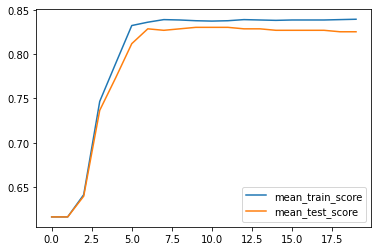

In [600]:
# SVC
svc = SVC(degree=1, C=0.1, random_state=1)
parameters = {'C': np.arange(0.01, 0.21, 0.01)
            # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            # 'degree': np.arange(1, 10, 1)
              }
svc = GridSearchCV(svc, param_grid=parameters, cv=5, n_jobs=-1, verbose=2, return_train_score=True)
svc.fit(X_train, y_train)
result_grid_svc = pd.DataFrame(svc.cv_results_)
print('SVC의 그리드서치 최고 모델: {}'.format(svc.best_estimator_))
print('SVC의 그리드서치 최고 파라미터: {}'.format(svc.best_params_))
print('SVC의 그리드서치 최고 점수: {}'.format(svc.best_score_))
train_score_svc = round(svc.score(X_train, y_train) * 100, 3)
val_score_svc = round(svc.score(X_val, y_val) * 100, 3)
print('SVC의 그리드서치 훈련(검증)세트 점수: {}({})'.format(train_score_svc, val_score_svc))
result_grid_svc[['mean_train_score', 'mean_test_score']].plot()
result_grid_svc[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score',
                 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score',
                 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.7s finished


AdaBoost의 그리드서치 최고 모델: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                   n_estimators=51, random_state=1)
AdaBoost의 그리드서치 최고 파라미터: {'n_estimators': 51}
AdaBoost의 그리드서치 최고 정확도: 83.394
AdaBoost의 그리드서치 훈련(검증)세트 점수: 83.893(83.051)


,params,mean_train_score,mean_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,{'n_estimators': 10},0.813761,0.808768,46,0.819328,0.800839,0.807128,0.823899,0.817610,0.783333,0.857143,0.831933,0.773109,0.798319
1,{'n_estimators': 11},0.811664,0.808768,46,0.819328,0.794549,0.805031,0.823899,0.815514,0.783333,0.865546,0.823529,0.773109,0.798319
2,{'n_estimators': 12},0.811663,0.807101,49,0.817227,0.794549,0.805031,0.823899,0.817610,0.775000,0.865546,0.823529,0.773109,0.798319
3,{'n_estimators': 13},0.812084,0.807101,48,0.819328,0.798742,0.805031,0.821803,0.815514,0.775000,0.857143,0.831933,0.773109,0.798319
4,{'n_estimators': 14},0.811245,0.808782,42,0.819328,0.798742,0.805031,0.817610,0.815514,0.775000,0.857143,0.831933,0.781513,0.798319
5,{'n_estimators': 15},0.812084,0.805420,50,0.819328,0.798742,0.805031,0.821803,0.815514,0.775000,0.857143,0.823529,0.773109,0.798319
6,{'n_estimators': 16},0.810406,0.810462,41,0.817227,0.798742,0.805031,0.817610,0.813417,0.775000,0.857143,0.831933,0.781513,0.806723
7,{'n_estimators': 17},0.811244,0.808782,42,0.817227,0.798742,0.805031,0.821803,0.813417,0.775000,0.857143,0.831933,0.773109,0.806723
8,{'n_estimators': 18},0.811663,0.808782,42,0.817227,0.798742,0.807128,0.821803,0.813417,0.775000,0.857143,0.831933,0.773109,0.806723
9,{'n_estimators': 19},0.812083,0.808782,42,0.817227,0.798742,0.807128,0.821803,0.815514,0.775000,0.857143,0.831933,0.773109,0.806723


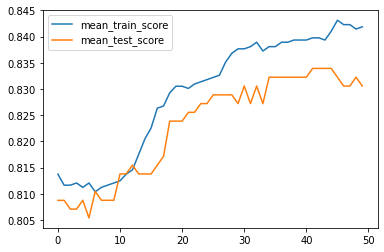

In [601]:
# AdaBoost
adaboost = AdaBoostClassifier(n_estimators=51, learning_rate=0.2, random_state=1)
parameters = {'n_estimators': np.arange(10, 60, 1)
            #   'learning_rate': np.arange(0.1, 1, 0.1)
              }
adaboost = GridSearchCV(adaboost, param_grid=parameters, cv=5, n_jobs=-1, verbose=2, return_train_score=True)
adaboost.fit(X_train, y_train)
result_grid_adaboost = pd.DataFrame(adaboost.cv_results_)
print('AdaBoost의 그리드서치 최고 모델: {}'.format(adaboost.best_estimator_))
print('AdaBoost의 그리드서치 최고 파라미터: {}'.format(adaboost.best_params_))
best_score_adaboost = round(adaboost.best_score_ * 100, 3)
print('AdaBoost의 그리드서치 최고 정확도: {}'.format(best_score_adaboost))
train_score_adaboost = round(adaboost.score(X_train, y_train)* 100, 3)
val_score_adaboost = round(adaboost.score(X_val, y_val) * 100, 3)
print('AdaBoost의 그리드서치 훈련(검증)세트 점수: {}({})'.format(train_score_adaboost, val_score_adaboost))
result_grid_adaboost[['mean_train_score', 'mean_test_score']].plot()
result_grid_adaboost[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score',
                 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score',
                 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[0]	validation_0-error:0.322034
Will train until validation_0-error hasn't improved in 2000 rounds.
[1]	validation_0-error:0.345763
[2]	validation_0-error:0.233898
[3]	validation_0-error:0.2
[4]	validation_0-error:0.20678
[5]	validation_0-error:0.213559
[6]	validation_0-error:0.213559
[7]	validation_0-error:0.20678
[8]	validation_0-error:0.20678
[9]	validation_0-error:0.186441
[10]	validation_0-error:0.186441
[11]	validation_0-error:0.2
[12]	validation_0-error:0.179661
[13]	validation_0-error:0.176271
[14]	validation_0-error:0.172881
[15]	validation_0-error:0.186441
[16]	validation_0-error:0.166102
[17]	validation_0-error:0.162712
[18]	validation_0-error:0.162712
[19]	validation_0-error:0.169492
[20]	validation_0-error:0.169492
[21]	validation_0-error:0.183051
[22]	validation_0-error:0.172881
[23]	validation_0-error:0.176271
[24]	validation_0-error:0.179661
[25]	validation_0-error:0.179661
[26]	validation_0-error:0.176271
[27]	validation_0-error:0.176271
[28]	validation_0-error:0.17627

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


[43]	validation_0-error:0.169492
[44]	validation_0-error:0.169492
[45]	validation_0-error:0.169492
[46]	validation_0-error:0.176271
[47]	validation_0-error:0.172881
[48]	validation_0-error:0.172881
[49]	validation_0-error:0.172881
XGBoost 그리드서치의 최적 파라미터: {'colsample_bynode': 0.1}
XGBoost 그리드서치의 최고 모델: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
              colsample_bynode=0.1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.6, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
XGBoost 그리드서치의 훈련(검증)세트 점수: 84.564(83.729)


,params,mean_train_score,mean_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,{'colsample_bynode': 0.1},0.834733,0.849034,1,0.838235,0.817610,0.825996,0.861635,0.830189,0.825000,0.873950,0.857143,0.848739,0.840336
1,{'colsample_bynode': 0.2},0.834733,0.849034,1,0.838235,0.817610,0.825996,0.861635,0.830189,0.825000,0.873950,0.857143,0.848739,0.840336
2,{'colsample_bynode': 0.30000000000000004},0.834733,0.849034,1,0.838235,0.817610,0.825996,0.861635,0.830189,0.825000,0.873950,0.857143,0.848739,0.840336
3,{'colsample_bynode': 0.4},0.834733,0.849034,1,0.838235,0.817610,0.825996,0.861635,0.830189,0.825000,0.873950,0.857143,0.848739,0.840336
4,{'colsample_bynode': 0.5},0.860746,0.833922,5,0.880252,0.836478,0.870021,0.853249,0.863732,0.816667,0.882353,0.840336,0.823529,0.806723
5,{'colsample_bynode': 0.6},0.860746,0.833922,5,0.880252,0.836478,0.870021,0.853249,0.863732,0.816667,0.882353,0.840336,0.823529,0.806723
6,{'colsample_bynode': 0.7000000000000001},0.860746,0.833922,5,0.880252,0.836478,0.870021,0.853249,0.863732,0.816667,0.882353,0.840336,0.823529,0.806723
7,{'colsample_bynode': 0.8},0.864090,0.823866,8,0.855042,0.842767,0.876310,0.874214,0.872117,0.800000,0.848739,0.831933,0.823529,0.815126
8,{'colsample_bynode': 0.9},0.864090,0.823866,8,0.855042,0.842767,0.876310,0.874214,0.872117,0.800000,0.848739,0.831933,0.823529,0.815126
9,{'colsample_bynode': 1.0},0.850262,0.817129,10,0.876050,0.815514,0.851153,0.849057,0.859539,0.808333,0.857143,0.823529,0.806723,0.789916


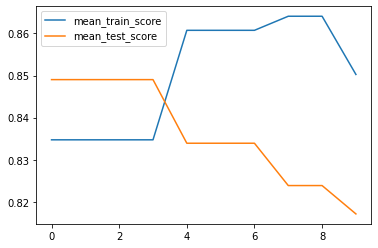

In [602]:
# XGBoost GridSearchCV
parameters={'colsample_bynode': np.arange(0.1, 1.1, 0.1),
           # 'colsample_bylevel': np.arange(0.1, 1.1, 0.1),
           # 'colsample_bytree': np.arange(0.1, 1.1, 0.1),
           # 'learning_rate': np.arange(0.1, 1.1, 0.1),
           # 'subsample': np.arange(0.1, 1.1, 0.1),
           # 'n_estimators': [50, 60, 70, 80, 90, 100],
           # 'max_depth': [2, 3, 4, 5, 6, 7]
            }
xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', n_estimators=50,
                    learning_rate=0.6, subsample=0.6,
                    colsample_bytree=0.5, colsample_bylevel=0.4, colsample_bynode=0.1,
                    max_depth=5, random_state=1)
xgb = GridSearchCV(xgb, param_grid=parameters, cv=5, n_jobs=-1, verbose=2,
                        return_train_score=True)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='error',
             early_stopping_rounds=2000)
result_grid_xgb = pd.DataFrame(xgb.cv_results_)

print('XGBoost 그리드서치의 최적 파라미터: {}'.format(xgb.best_params_))
print('XGBoost 그리드서치의 최고 모델: {}'.format(xgb.best_estimator_))
train_score_xgb = round(xgb.score(X_train, y_train) * 100, 3)
val_score_xgb = round(xgb.score(X_val, y_val) * 100, 3)
print('XGBoost 그리드서치의 훈련(검증)세트 점수: {}({})'.format(train_score_xgb, val_score_xgb))
result_grid_xgb[['mean_train_score', 'mean_test_score']].plot()
result_grid_xgb[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score',
                 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score',
                 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.8s finished


GBC의 그리드서치 최고 모델: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=19, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GBC의 그리드서치 최적 파라미터: {'max_features': 19}
GBC의 그리드서치 훈련(검증)점수: 86.074(83.051)


,params,mean_train_score,mean_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,{'max_features': 2},0.851930,0.835602,14,0.852941,0.851153,0.844864,0.863732,0.846960,0.816667,0.865546,0.848739,0.815126,0.831933
1,{'max_features': 3},0.846058,0.832255,16,0.848739,0.846960,0.846960,0.844864,0.842767,0.808333,0.882353,0.840336,0.806723,0.823529
2,{'max_features': 4},0.849835,0.835616,12,0.857143,0.842767,0.853249,0.849057,0.846960,0.808333,0.890756,0.848739,0.806723,0.823529
3,{'max_features': 5},0.850673,0.830574,19,0.855042,0.849057,0.853249,0.851153,0.844864,0.808333,0.865546,0.840336,0.806723,0.831933
4,{'max_features': 6},0.851933,0.827213,20,0.859244,0.851153,0.853249,0.849057,0.846960,0.808333,0.857143,0.831933,0.806723,0.831933
5,{'max_features': 7},0.857383,0.832255,16,0.859244,0.859539,0.857442,0.859539,0.851153,0.808333,0.865546,0.840336,0.815126,0.831933
6,{'max_features': 8},0.857383,0.832255,16,0.859244,0.855346,0.861635,0.857442,0.853249,0.808333,0.865546,0.831933,0.815126,0.840336
7,{'max_features': 9},0.860318,0.833936,15,0.859244,0.863732,0.859539,0.863732,0.855346,0.808333,0.865546,0.831933,0.823529,0.840336
8,{'max_features': 10},0.860739,0.835616,12,0.863445,0.865828,0.861635,0.861635,0.851153,0.808333,0.873950,0.831933,0.823529,0.840336
9,{'max_features': 11},0.865353,0.840658,8,0.867647,0.865828,0.863732,0.876310,0.853249,0.808333,0.882353,0.831933,0.840336,0.840336


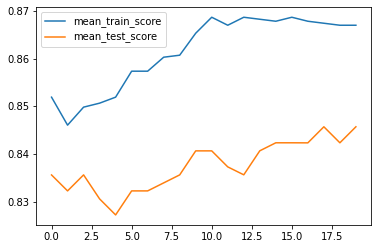

In [603]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=250, max_depth=3, 
                                 max_features=22, learning_rate=0.01, random_state=1)
parameters = {'max_features': np.arange(2, 22, 1)
            # 'learning_rate': np.arange(0.001, 0.011, 0.001)
            # 'n_estimators': np.arange(240, 260, 1)
            # 'max_depth': [2, 3, 4, 5, 6, 7]
              }
gbc = GridSearchCV(gbc, param_grid=parameters, cv=5, verbose=2, n_jobs=-1, return_train_score=True)
gbc.fit(X_train, y_train)
result_grid_gbc = pd.DataFrame(gbc.cv_results_)
print('GBC의 그리드서치 최고 모델: {}'.format(gbc.best_estimator_))
print('GBC의 그리드서치 최적 파라미터: {}'.format(gbc.best_params_))
train_score_gbc = round(gbc.score(X_train, y_train) * 100, 3)
val_score_gbc = round(gbc.score(X_val, y_val) * 100, 3)
print('GBC의 그리드서치 훈련(검증)점수: {}({})'.format(train_score_gbc, val_score_gbc))
result_grid_gbc[['mean_train_score', 'mean_test_score']].plot()
result_grid_gbc[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score',
                 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score',
                 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   40.4s finished


MLP의 그리드서치 최고 모델: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=600, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=219,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.001, validation_fraction=0.1, verbose=False,
              warm_start=False)
MLP의 그리드서치 최고 파라미터: {'tol': 0.001}
MLP의 그리드서치 평균 훈련(검증)세트 점수: 0.8414477740781848(0.8356442577030812)
MLP의 그리드서치 훈련(검증)세트 정확도: 84.396(82.373)


,params,mean_train_score,mean_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,{'tol': 0.1},0.795303,0.788627,9,0.798319,0.794549,0.790356,0.800839,0.792453,0.766667,0.789916,0.823529,0.773109,0.789916
1,{'tol': 0.01},0.828445,0.827213,8,0.842437,0.819706,0.819706,0.830189,0.830189,0.808333,0.840336,0.840336,0.815126,0.831933
2,{'tol': 0.001},0.841448,0.835644,1,0.852941,0.830189,0.844864,0.842767,0.836478,0.791667,0.857143,0.831933,0.840336,0.857143
3,{'tol': 0.0001},0.840186,0.833950,2,0.844538,0.828092,0.849057,0.842767,0.836478,0.800000,0.857143,0.831933,0.831933,0.848739
4,{'tol': 1e-05},0.840186,0.833950,2,0.844538,0.828092,0.849057,0.842767,0.836478,0.800000,0.857143,0.831933,0.831933,0.848739
5,{'tol': 1e-06},0.840186,0.833950,2,0.844538,0.828092,0.849057,0.842767,0.836478,0.800000,0.857143,0.831933,0.831933,0.848739
6,{'tol': 1e-07},0.840186,0.833950,2,0.844538,0.828092,0.849057,0.842767,0.836478,0.800000,0.857143,0.831933,0.831933,0.848739
7,{'tol': 1e-08},0.840186,0.833950,2,0.844538,0.828092,0.849057,0.842767,0.836478,0.800000,0.857143,0.831933,0.831933,0.848739
8,{'tol': 1e-09},0.840186,0.833950,2,0.844538,0.828092,0.849057,0.842767,0.836478,0.800000,0.857143,0.831933,0.831933,0.848739


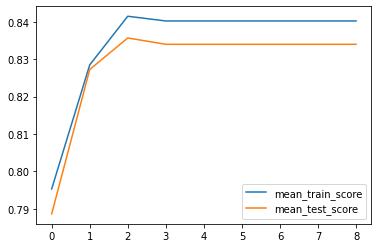

In [604]:
# Multilayer Perceptron
mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(600), max_iter=219, random_state=1)
parameters = {'tol': [(10) ** (-n) for n in range(1, 10)]
              # 'hidden_layer_sizes': [(600), (300, 300), (500, 500), (300, 300, 300)]
              # 'activation': ['relu', 'tanh', 'identity', 'logistic']
              # 'max_iter': np.arange(210, 230, 1)
              }
mlp = GridSearchCV(mlp, param_grid=parameters, cv=5, n_jobs=-1, verbose=2, return_train_score=True)
mlp.fit(X_train, y_train)
result_grid_mlp = pd.DataFrame(mlp.cv_results_)
print('MLP의 그리드서치 최고 모델: {}'.format(mlp.best_estimator_))
print('MLP의 그리드서치 최고 파라미터: {}'.format(mlp.best_params_))
print('MLP의 그리드서치 평균 훈련(검증)세트 점수: {}({})'.format(result_grid_mlp.loc[mlp.best_index_,'mean_train_score'],
                                                 result_grid_mlp.loc[mlp.best_index_, 'mean_test_score']))
train_score_mlp = round(mlp.score(X_train, y_train) * 100, 3)
val_score_mlp = round(mlp.score(X_val, y_val) * 100, 3)
print('MLP의 그리드서치 훈련(검증)세트 정확도: {}({})'.format(train_score_mlp, val_score_mlp))
result_grid_mlp[['mean_train_score', 'mean_test_score']].plot()
result_grid_mlp[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score',
                 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score',
                 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:    0.0s finished


building tree 1 of 16
building tree 2 of 16
building tree 3 of 16building tree 4 of 16

building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16building tree 9 of 16

building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16building tree 15 of 16

building tree 16 of 16
랜덤포레스트의 그리드서치 최고 모델: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=7, max_samples=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=3,
                       warm_start=False)
랜덤포레스트의 그리드서치 최고 파라미터: {'max_samples': 100}
랜덤포레스트의 그리드서치 훈련(검증)세트 정확도: 81.879(83.729

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:    0.0s finished


,params,mean_train_score,mean_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,{'max_samples': 90},0.827602,0.818852,3,0.829832,0.802935,0.832285,0.834382,0.838574,0.783333,0.865546,0.831933,0.773109,0.840336
1,{'max_samples': 100},0.835989,0.832269,1,0.834034,0.815514,0.834382,0.855346,0.840671,0.800000,0.882353,0.831933,0.823529,0.823529
2,{'max_samples': 110},0.829702,0.822199,2,0.840336,0.823899,0.825996,0.823899,0.834382,0.791667,0.882353,0.831933,0.773109,0.831933


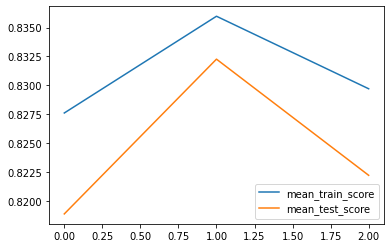

In [605]:
# Random Forest GridSearch
rf = RandomForestClassifier(n_estimators=16, max_depth=4,
                            max_leaf_nodes=7, max_samples=100, min_samples_split=10, n_jobs=-1, verbose=3, random_state=1)
parameters = {'max_samples': np.arange(90, 120, 10)
             # 'min_samples_split': np.arange(1, 20, 1),
             # 'n_estimators': np.arange(2, 50, 1),
             # 'max_leaf_nodes': np.arange(2, 10, 1),
              }
rf = GridSearchCV(rf, param_grid=parameters, cv=5, n_jobs=-1, verbose=2, return_train_score=True)
rf.fit(X_train, y_train)
result_grid_rf = pd.DataFrame(rf.cv_results_)
print('랜덤포레스트의 그리드서치 최고 모델: {}'.format(rf.best_estimator_))
print('랜덤포레스트의 그리드서치 최고 파라미터: {}'.format(rf.best_params_))
train_score_rf = round(rf.score(X_train, y_train) * 100, 3)
val_score_rf = round(rf.score(X_val, y_val) * 100, 3)
print('랜덤포레스트의 그리드서치 훈련(검증)세트 정확도: {}({})'.format(train_score_rf, val_score_rf))
result_grid_rf[['mean_train_score', 'mean_test_score']].plot()
result_grid_rf[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score',
                 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score',
                 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

In [606]:
# # XGBoost
# xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', n_estimators=10000,
#                     learning_rate=0.01, subsample=0.6,
#                     colsample_bytree=0.3, colsample_bylevel=0.7, colsample_bynode=0.9,
#                     max_depth=5, random_state=1)
# xgb.fit(X_train, y_train, eval_metric='error', eval_set=[(X_val, y_val)],
#         early_stopping_rounds=2000)
# train_score_xgb = round(xgb.score(X_train, y_train) * 100, 3)
# val_score_xgb = round(xgb.score(X_val, y_val) * 100, 3)
# print('XGBoost의 훈련(검증)세트 정확도: {}({})'.format(train_score_xgb, val_score_xgb))

# # SVC
# svc = SVC(degree=1, random_state=1)
# svc.fit(X_train, y_train)
# train_score_svc = round(svc.score(X_train, y_train) * 100, 3)
# val_score_svc = round(svc.score(X_val, y_val) * 100, 3)
# print('SVC의 훈련(검증)세트 정확도: {}({})'.format(train_score_svc, val_score_svc))

# # AdaBoost
# adaboost = AdaBoostClassifier(random_state=1)
# adaboost.fit(X_train, y_train)
# train_score_adaboost = round(adaboost.score(X_train, y_train) * 100, 3)
# val_score_adaboost = round(adaboost.score(X_val, y_val) * 100, 3)
# print('AdaBoost의 훈련(검증)세트 정확도: {}({})'.format(train_score_adaboost, val_score_adaboost))

# # Random Forest
# rf = RandomForestClassifier(max_depth=4, max_features=4, n_estimators=1000, random_state=1)
# rf.fit(X_train, y_train)
# train_score_rf = round(rf.score(X_train, y_train) * 100, 3)
# val_score_rf = round(rf.score(X_val, y_val) * 100, 3)
# print('랜덤포레스트의 훈련(검증)세트 정확도: {}({})'.format(train_score_rf, val_score_rf))

# # Gradient Boosting Classifier
# gbc = GradientBoostingClassifier(max_features=4, max_depth=4, random_state=1)
# gbc.fit(X_train, y_train)
# train_score_gbc = round(gbc.score(X_train, y_train) * 100, 3)
# val_score_gbc = round(gbc.score(X_val, y_val) * 100, 3)
# print('GBC의 훈련(검증)세트 정확도: {}({})'.format(train_score_gbc, val_score_gbc))

# # Multilayer Perceptron
# mlp = MLPClassifier(hidden_layer_sizes=(200, 200), activation='relu', max_iter=2000, random_state=1)
# mlp.fit(X_train, y_train)
# train_score_mlp = round(mlp.score(X_train, y_train) * 100, 3)
# val_score_mlp = round(mlp.score(X_val, y_val) * 100, 3)
# print('MLP의 훈련(검증)세트 정확도: {}({})'.format(train_score_mlp, val_score_mlp))

# # Decision Tree
# dtree = DecisionTreeClassifier(max_depth=8, max_features=5, random_state=1)
# dtree.fit(X_train, y_train)
# train_score_dtree = round(dtree.score(X_train, y_train) * 100, 3)
# val_score_dtree = round(dtree.score(X_val, y_val) * 100, 3)
# print('결정트리의 훈련(검증)세트 정확도: {}({})'.format(train_score_dtree, val_score_dtree))

# # Logistic Regression
# logreg = LogisticRegression(max_iter=20000, random_state=1)
# logreg.fit(X_train, y_train)
# train_score_logreg = round(logreg.score(X_train, y_train) * 100, 3)
# val_score_logreg = round(logreg.score(X_val, y_val) * 100, 3)
# print('로지스틱회귀의 훈련(검증)세트 정확도: {}({})'.format(train_score_logreg, val_score_logreg))

# # Linear SVC
# linear_svc = LinearSVC(max_iter=2000, random_state=1)
# linear_svc.fit(X_train, y_train)
# train_score_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 3)
# val_score_linear_svc = round(linear_svc.score(X_val, y_val) * 100, 3)
# print('LinearSVC의 훈련(검증)세트 정확도: {}({})'.format(train_score_linear_svc, val_score_linear_svc))

# # K-Neighbors Classfier
# knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)
# train_score_knn = round(knn.score(X_train, y_train) * 100, 3)
# val_score_knn = round(knn.score(X_val, y_val) * 100, 3)
# print('KNN의 훈련(검증)세트 정확도: {}({})'.format(train_score_knn, val_score_knn))

# # Stochastic Gradient Decent
# sgd = SGDClassifier(random_state=1)
# sgd.fit(X_train, y_train)
# train_score_sgd = round(sgd.score(X_train, y_train) * 100, 3)
# val_score_sgd = round(sgd.score(X_val, y_val) * 100, 3)
# print('SGD의 훈련(검증)세트 정확도: {}({})'.format(train_score_sgd, val_score_sgd))

In [607]:
# 머신러닝 모델 중에 가장 높은 교차검증 점수를 갖는 모델을 선택한다.
models = pd.DataFrame([
                    #   ['KNN', train_score_knn, val_score_knn, knn],
                    #   ['Decision Tree', train_score_dtree, val_score_dtree, dtree],
                    #   ['Linear SVC', train_score_linear_svc, val_score_linear_svc, linear_svc],
                    #   ['Stochastic Gradient Decent', train_score_sgd, val_score_sgd, sgd],
                    #   ['Logistic Regression', train_score_logreg, val_score_logreg, logreg],
                      ['MLP', train_score_mlp, val_score_mlp, mlp],
                      ['Random Forest', train_score_rf, val_score_rf, rf],
                      ['Gradient Boosting Classifier', train_score_gbc, val_score_gbc, gbc],
                      ['SVC', train_score_svc, val_score_svc, svc],
                      ['AdaBoost', train_score_adaboost, val_score_adaboost, adaboost],
                      ['XGB', train_score_xgb, val_score_xgb, xgb]
],
                    columns=['model', 'train_score', 'val_score', 'estimator'])
models['train-val'] = models['train_score'] - models['val_score']
sorted_models = models.sort_values(by=['val_score'], axis=0, ascending=False,
                                   ignore_index=True).loc[:,['model', 'train_score', 'val_score', 'train-val']]
best_estimator = models.sort_values(by=['val_score'], axis=0, ascending=False,
                                    ignore_index=True).loc[:,['estimator', 'val_score', 'train-val']]
print(sorted_models)
print('-' * 40)
print('검증 세트 정확도가 가장 높은 모델은 {}이고 점수는 {}이다'.format(sorted_models.iloc[0, 0], sorted_models.iloc[0, 2]))
y_test = best_estimator.iloc[0, 0].predict(X_test)

                          model  train_score  val_score  train-val
0                 Random Forest       81.879     83.729     -1.850
1                           XGB       84.564     83.729      0.835
2  Gradient Boosting Classifier       86.074     83.051      3.023
3                           SVC       83.725     83.051      0.674
4                      AdaBoost       83.893     83.051      0.842
5                           MLP       84.396     82.373      2.023
----------------------------------------
검증 세트 정확도가 가장 높은 모델은 Random Forest이고 점수는 83.729이다


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:    0.0s finished


In [608]:
# 결과를 CSV로 저장한다.
submission = pd.DataFrame({'PassengerId': test_id, 'Survived': y_test})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/titanic/submission.csv', index=False)

In [609]:
# perm = PermutationImportance(best_estimator.iloc[0, 0], scoring='accuracy', random_state=10).fit(X_val, y_val) 
# eli5.show_weights(perm, top=None, feature_names=X_test.columns.tolist())
# # sorted(sklearn.metrics.SCORERS.keys())